In [2]:
import tensorflow as tf
keras = tf.keras
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# %run ../src/acc_df.py
# Ac = Acc_data('../data/cleaned/coll_coord.csv')
# acc = Ac.get_all_coll() #['']

### 1. Turn it into a time series of weeks

In [4]:
week_numbers = pd.read_csv('../../data/cleaned/weekseries_05_18.csv')

In [5]:
week_numbers.head(2),week_numbers.tail(2)

(           ds  acc_nr
 0  2005-01-02     275
 1  2005-01-09     308,              ds  acc_nr
 729  2018-12-23     234
 730  2018-12-30     150)

In [6]:
acc_nr_bw = week_numbers.acc_nr.values #[:100]
len(acc_nr_bw)

731

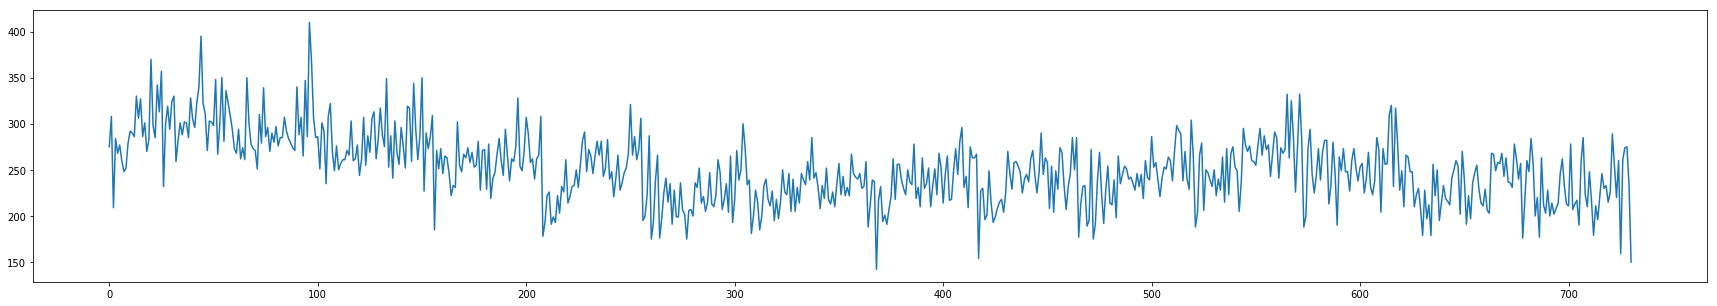

In [7]:
fig, ax = plt.subplots(figsize=(30,5))
ax.plot(week_numbers.index.values, acc_nr_bw)

#### Windowize and split

In [8]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

In [9]:
# windowize_data(week_numbers.index.values,20)

In [10]:
def split_and_windowize(data, n_prev, fraction_test=0.3):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [11]:
n_prev = 50
x_train, x_test, y_train, y_test = split_and_windowize(acc_nr_bw, n_prev, fraction_test=0.01)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((575, 50, 1), (56, 50, 1), (575,), (56,))

#### Model

In [27]:
model = keras.Sequential()
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(60, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(60, return_sequences=False))
model.add(keras.layers.Dense(1, activation='relu'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

### Train

In [28]:
model.fit(x_train, y_train, batch_size=32, epochs=400)

Train on 575 samples
Epoch 1/400
575/575 [==============================] - 8s 13ms/sample - loss: 61125.0130
Epoch 2/400
575/575 [==============================] - 3s 5ms/sample - loss: 58699.9908
Epoch 3/400
575/575 [==============================] - 3s 5ms/sample - loss: 57982.2494
Epoch 4/400
575/575 [==============================] - 3s 5ms/sample - loss: 57404.7995
Epoch 5/400
575/575 [==============================] - 3s 5ms/sample - loss: 56865.3165
Epoch 6/400
575/575 [==============================] - 3s 5ms/sample - loss: 56341.2651
Epoch 7/400
575/575 [==============================] - 3s 5ms/sample - loss: 55823.4838
Epoch 8/400
575/575 [==============================] - 3s 5ms/sample - loss: 55310.5991
Epoch 9/400
575/575 [==============================] - 3s 5ms/sample - loss: 54802.2785
Epoch 10/400
575/575 [==============================] - 3s 5ms/sample - loss: 54296.7370
Epoch 11/400
575/575 [==============================] - 3s 5ms/sample - loss: 53793.7331
Epoch 12

In [22]:
y_pred = model.predict(x_test)
y_pred[:5]

array([[226.90533],
       [226.90533],
       [226.90533],
       [226.90533],
       [226.90533]], dtype=float32)

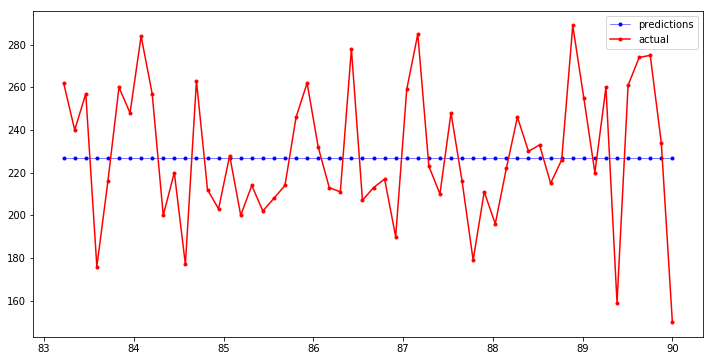

In [23]:
n_pts = len(acc_nr_bw)
t = np.linspace(0, 15 * 6, n_pts)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.-', label='actual')
ax.legend()

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred,y_test)

1004.5805775986186

Text(0.5, 0, 'epoch')

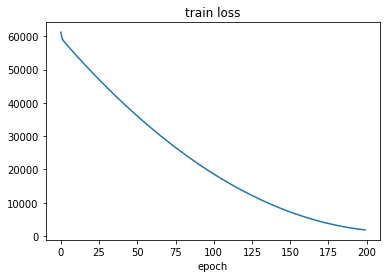

In [25]:
history = model.history
plt.title("train loss")
plt.plot( history.history["loss"] )
plt.xlabel("epoch")

In [17]:
import datetime as dt
filename = 'models/lstm_8_{}_{}'.format(dt.datetime.now().day,dt.datetime.now().minute)
# model.save(filename)

#### next try